# Comparison between ECE and Calibration loss

This notebook compares ECE with calibration loss obtained using different calibration approaches. It explores the issue of overfitting the calibration transform, and the effect of the train-on-test approach.


In [1]:
#import torch 
import matplotlib.pyplot as plt
import numpy as np
from expected_cost import ec, utils
from expected_cost.data import create_scores_for_expts
from expected_cost.psrcal_wrappers import Brier, LogLoss, ECE, ECEbin, CalLoss
from psrcal.losses import plot_reliability_diagram

## Create the scores

In the cell below we use a method from the expected_cost repository that generates a lot of different
scores, calibrated, miscalibrated and re-calibrated by applying calibration transformation to the original calibrated or miscalibrated scores. 

In [2]:
# Create some simulated data for the experiments. You can play with the parameters below to create
# data for different number of classes (K), different priors (P0), different number of samples (N),
# and different difficulty (std).
P0 = 0.8
K = 2
N = 500 * K
std = 0.15

# Number of bins used for histogram binning
nbins = 15

# The method below creates a bunch of different scores, all with the same targets and puts them in
# score_dict.
score_dict, targets = create_scores_for_expts(K, P0=P0, feat_std=std, N=N, calibrate=True, simple_names=True, nbins=nbins)

# The score_dict has four different scores:
# cal: perfectly calibrated scores
# mcp: scores miscalibrated due to a mismatch in priors between the training and the test data
# mcs: scores miscalibrated due to (simulated) overfitting of the model
# mcps: scores miscalibrated due to both causes above

# Each of them is post-hoc calibrated in three different ways
# Affcal: affine transform of the log-posteriors
# Temcal: only scaling of the log-posteriors (same as above but without the shift)
# Hiscal: histogram binning, as done for ECE

# And two ways of training each of those models
# tt: train-on-test (cheating, as done for ECE)
# xv: cross-validation on the test data (non-cheating)     
    



## Compute two Brier score and cross-entropy

We can now compute two EPSRs to assess the quality of the scores as posteriors, Brier score and cross-entropy. This allows us to analyze the effect of the different post-hoc calibrators on the calibrated and miscalibrated scores.

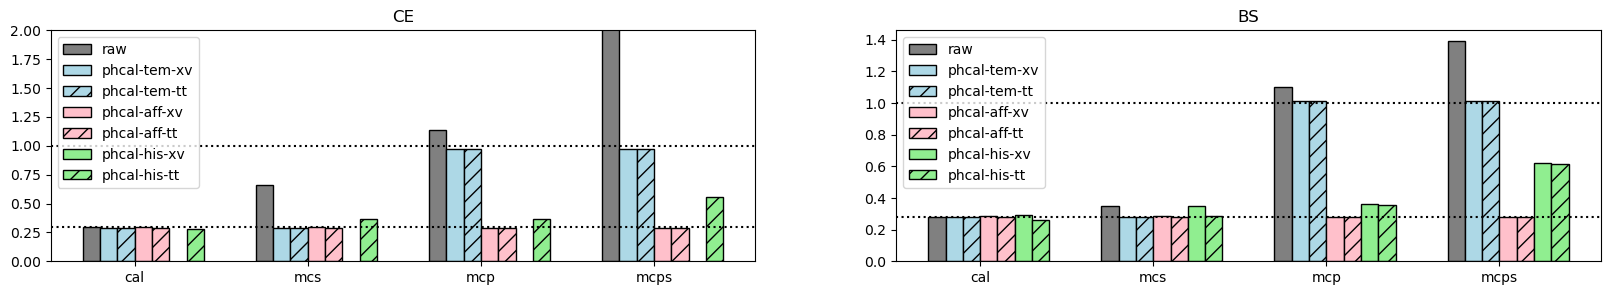

In [3]:
metric_dict = {
    'CE': LogLoss, 
    'BS': Brier
    }

color = ['grey', 'lightblue', 'lightblue', 'pink', 'pink', 'lightgreen', 'lightgreen', 'yellow', 'yellow']
score_names = ['cal', 'mcs', 'mcp', 'mcps']

# Explore calibration methods: none, temp scaling and affine
calmethods = ['', 'tem', 'aff']
if K==2:
    # For the binary case, we can also do histogram binning
    calmethods.append('his')

barWidth = 1/(2.5*len(calmethods))

fig, axs = plt.subplots(1,len(metric_dict), figsize=(20,3))

for i, (metric_name, metric) in enumerate(metric_dict.items()):

    ax = axs[i]
    j = 0

    for calmethod in calmethods:

        trntypes = ['xv', 'tt'] if calmethod != '' else ['']

        for trntype in trntypes:

            yvalues = []
            for score_name in score_names:
                score_name_cal = f"{score_name}-{calmethod}cal{trntype}" if calmethod != '' else score_name
                yvalues.append(metric(score_dict[score_name_cal], targets))

            xvalues = np.arange(len(score_names)) + barWidth * j
            label = f"phcal-{calmethod}-{trntype}" if calmethod != '' else 'raw'
            ax.bar(xvalues, yvalues, color =color[j], edgecolor='k', width = barWidth, label = label, 
                   hatch='' if trntype!='tt' else '//')
            j += 1

    ax.legend() 
    ax.set_xticks(np.arange(len(score_names)) + barWidth * 2.5, score_names)

    xvalues = ax.get_xlim()
    cal_perf = metric(score_dict['cal'],targets)
    ax.plot(xvalues, np.ones_like(xvalues), ':k')
    ax.plot(xvalues, np.ones_like(xvalues)*cal_perf, ':k')
    ax.set_xlim(xvalues)
    ax.set_title(metric_name)
    ax.set_ylim([0, min(2,ax.get_ylim()[1])])


In the plot above, each group of bars corresponds to the EPSR of one set of scores as they come out of the system (raw) and after various post-hoc calibration approaches (phcal). The x-axis name indicates which raw scores are used for each group of bars, the ones that are calibrated by constructions (cal) or any of the three miscalibrated ones (mcs, mcp, mcps). For the cal scores, post-hoc calibration should ideally not have any effect since there is nothing to fix. For the other scores, it should bring the EPSR down to the level of the cal scores. 

Some observations from the plot above when setting K=10:

1. While the trends in CE and BS are similar, they are not identical. CE penalizes the miscalibration due to scaling in mcs and mcps (simulating overfitting) much more than BS. This is because CE penalizes extreme mistakes (posterior close to 0 for the correct class) much more than BS and overfitting makes extreme mistakes more frequent. 

2. Temp scaling cannot be used for calibrating scores for which the priors are incorrect (mcp and mcps). This is because it does not have a shift parameters which is what is needed to correct the mismatch in priors. 

3. Affine calibration, on the other hand, successfully fixes the calibration problems in all miscalibrated scores (mcs, mcp, and mcps). 

If we set K=2, we can also do histogram binning. In that case we can see that:

1. Observations 1, 2, and 3 above still hold. 

2. The missing green bars are due to the fact that histogram binning mapped some scores to exactly 0, which led to CE of infinity. This is one of the disadvantages of histogram binning for calibration.

3. For the cal scores, histogram binning trained on test data shows some degree of overfitting (performance is slightly better than for the cal scores, which should not be the case).

4. Further, histogram binning does not quite fix the calibration problems, even when cheating. This is because the number of bins being used does not given enough flexibility to the model. Using more bins, though, would make the method more prone to overfitting and it still may not fix the problem when the scores are all accumulated at the extremes on the very first bin on each side. This problem can be mitigated by determining the bins in an adaptive manner instead of by dividing the [0,1] range in equal bins. We do not explore these alternative methods since our goal here is not to do an exhaustive comparison of all possible calibration methods but, rather, to show how to properly evaluate them. 

The clear advantage of affine calibration in the results above is, in part, a consequence of how the miscalibrated scores are created. They are, by construction, created as affine transformations of the calibrated scores. Hence, the assumption behind affine calibration is perfectly satisfied for these scores. Nevertheless, we would like to point out that, in our experience, affine calibration has worked very well on log-posteriors from DNNs, SVMs, and several other classifiers we have tried it on. 

In the end, though, all that's needed is a non-cheating method for evaluating various calibration methods. If you are not sure whether affine calibration will work well on your scores, you can try it, along with temperature scaling and histogram binning, using cross-validation on the test data or using a held-out set for training the calibration model, and simply compare the results to select the best method. If you do train-on-test, though, and then choose the best model on the test data you might end up choosing a suboptimal model, the one that managed to overfit the test data the most.


## Compute and compare calibration metrics

We can now compute calibration loss with any of the post-hoc calibrated scores above. That is, for each, raw score we can compute calibration loss as:

$$\text{RelCalLoss} = 100 \ (\text{EPSRraw} - \text{EPSRmin})/\text{EPSRraw}$$

where EPSRmin can be computed as the EPSR obtained after any of the post-hoc calibration approaches used above. So, we can compute a CalLoss for each colored bar above as the relative difference between the grey bar and the corresponding colored bar. These metrics give us different estimates of the calibration error obtained with different calibration approaches. Some of these estimates are better than others, of course. The better estimates are those for which the EPSRmin is close to the EPSR of the cal-raw scores which, for these simulated scores, we know to be the "true" EPSRmin. In the plot below we show the "true" value of RelCalLoss obtained using this true EPSRmin. 

In practice, of course, we would not know what the true EPSRmin is. All we can aim for is to get the smallest EPSR possible without cheating. The smallest EPSR we are able to achieve may not be the actual minimum, but it is our best estimate and we can keep trying different methods until we are satisfied that we have done our best effort. The beauty of using CalLoss as calibration metric is that we are simultaneously measuring calibration loss, developing the post-hoc calibrator, and estimating the performance of the system we would obtain after adding that calibrator to our system.

The ECE, by the way, is also going through the trouble of developing a post-hoc calibrator (a histogram binning calibrator). In fact, any calibration metric will have to, explicitly or implicitly, create a model for the reference posterior distribution (i.e., a calibrator) and compare the scores to that distribution. Calibration loss does this explicitly, resulting in a metric with a very clear interpretation.

For comparison, in the plots below we also add the ECE metric. For the binary case, the ECE is obtained with the histogram-binned scores with train-on-test training. For the multi-class case, the problem is first turned into a binary problem by keeping only the largest posterior and labelling each sample as being class 2 if the class with the largest posterior is the correct class, and class 1 otherwise. Then, the standard ECE is computed on this new binary problem. Note that this means that all posteriors other than the largest one are ignored when computing the multi-class ECE. This is the standard way in which ECE is computed in the literature for multi-class classification. We believe this is a rather unfortunate practice since, as the example shows, evaluating only the largest posterior may result in underestimation of the calibration error. Calibration loss offers a much more elegant and principled solution to measuring calibration which naturally generalizes to the multi-class case.

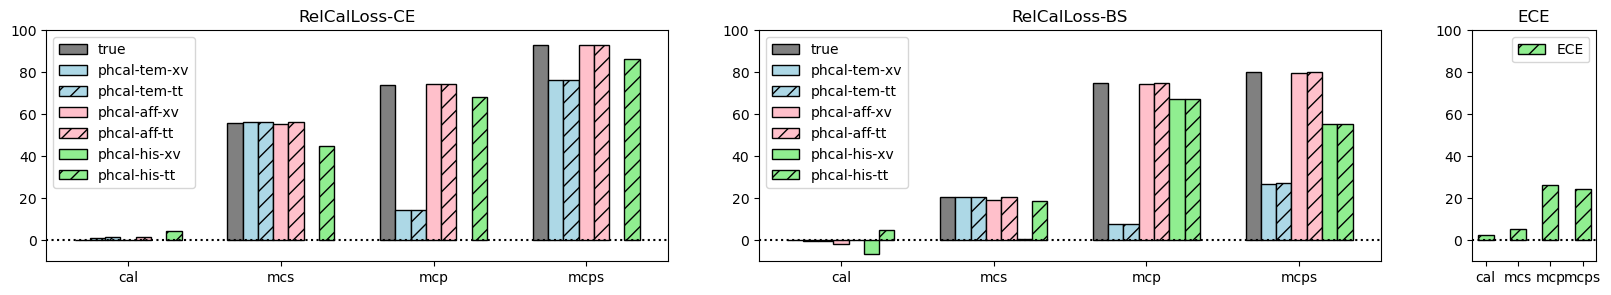

In [4]:
# Compute and plot the calibration metrics

metric_dict = {'RelCalLoss-CE': LogLoss, 
               'RelCalLoss-BS': Brier, 
               'ECE': ECEbin if K==2 else ECE}

trntypes = ['xv', 'tt']

fig, axs = plt.subplots(1,len(metric_dict), figsize=(20,3), gridspec_kw={'width_ratios': [5, 5, 1]})

for i, (metric_name, metric) in enumerate(metric_dict.items()):

    ax = axs[i]

    if "ECE" in metric_name:

        barWidth = 0.5
        yvalues = []
        for score_name in score_names:
            yvalues.append(metric(score_dict[score_name], targets, M=nbins))
        xvalues = np.arange(len(score_names)) 
        ax.bar(xvalues, yvalues, color = color[5], edgecolor='k', width = barWidth, label = metric_name, hatch='//')    
        j = 1

    else:
        j = 0
        barWidth = 1/(2.5*len(calmethods))

        for calmethod in calmethods:

            for trntype in trntypes:

                if calmethod == '' and trntype == 'tt': continue
                yvalues = []

                for score_name in score_names:
                    if calmethod == '': 
                        # Compute the "true" calibration loss taking EPSRmin to be the EPSR of the cal-raw scores
                        score_name_cal = "cal"
                    else:
                        score_name_cal = f"{score_name}-{calmethod}cal{trntype}" if calmethod != '' else score_name

                    yvalues.append(CalLoss(metric, score_dict[score_name], score_dict[score_name_cal], targets))

                xvalues = np.arange(len(score_names)) + barWidth * j
                label = f"phcal-{calmethod}-{trntype}" if calmethod != '' else 'true'
                ax.bar(xvalues, yvalues, color =color[j], edgecolor='k', width = barWidth, label = label, 
                    hatch='' if trntype!='tt' else '//')
                j += 1

    ax.legend() 
    ax.set_xticks(np.arange(len(score_names)) + barWidth * (j-1)/2, score_names)

    xvalues = ax.get_xlim()
    cal_perf = metric(score_dict['cal'],targets)
    ax.plot(xvalues, np.zeros_like(xvalues), ':k')
    ax.set_xlim(xvalues)
    ax.set_title(metric_name)
    yl = ax.get_ylim()
    ax.set_ylim([-10, 100])


Observations from the plots above for the K=10 case (the first bullets are trivial consequences of the corresponding observations in the cell above):

1. The calibration loss for the mcs scores computed based on Brier score is much smaller than when computed with cross-entropy. As mentioned above, this is because cross-entropy penalizes extreme errors due to overfitting much more than Brier score.

2. Temp scaling underestimates the calibration error for two of the miscalibrated scores, mcp and mcps. This is because temp scaling, as discussed above, does not do a good job of calibrating these scores reaching a very bad model for the reference posterior distribution. In particular, for the mcp scores, it suggests perfect calibration which we know to be wrong for these scores. 

3. Affine calibration gives a spot-on value for the calibration error when using cross-validation to get the calibrated scores.

4. The relative calibration loss emphasizes the problem with training on test data (this issue is harder to appreciate in the previous figure with absolute BS and CE values before and after calibration): this way of getting the calibrated scores can lead to an overestimation of the calibration error due to the calibration transform overfitting the test data.

5. ECE tells us that mcps is much more severely miscalibrated than the other two scores, which is different from what the RelCalLoss values tell us. While the two RelCalLoss, computed with BS or CE, are different from each other, we can understand why they are different (see bullet 1 above). The values ECE is giving us are much more obscure. Too many things can explain those values (a bad fit of the transform, overfitting of the transform, the mapping of the multi-class problem into a binary one). 
   
6. Further, note that the ECE values are much smaller than those of the RelCalLoss. Those values have no direct interpretation, while the RelCalLoss values do. RelCalLoss is the percentage of the performance of the raw scores that can be improved by calibration; a very straightforward interpretable value. ECE, on the other hand is the average gap in the reliability plot. What do those values mean? Is an ECE of 10 large or small? How much impact would calibration have on my system if its ECE is 10? We have no way to tell. 

For K=2 we can add the histogram binning results and draw some further conclusions:
   
5. The RelCalLoss based on histogram binning is either too large or too small, but never what it should be (the grey bars). It is too small because the fixed-width bins are pretty bad for the miscalibrated scores. It is too large for cal when trained on test data because it overfits. 

6. The trend in ECE values is identical to that seen in RelCalLoss-BS with trained-on-test histogram binning, since that is the transform behind ECE. The difference in metric value is just due to the way the distance between the raw and the calibrated scores is calculated. In this example its value is about half of the RelCalLoss, but this does not hold for other datasets (you can try changing std in the first cell to experiment with this). 


In conclusions, we hope these results are enough to convince the reader that ECE is a problematic metric which can be very easily improved upon. At the very least, for the binary case, one can use RelCalLoss-BS with train-on-test histogram binning. This is already an improvement since RelCalLoss is much more interpretable than ECE. But one can also use calibration methods that are better than histogram binning, and train them without cheating. 
    




## Plot reliability diagrams

The reliability diagrams for all scores are included below. Further, we include another version of these plots where we draw curves for all the quantities involved in the computation of the ECE. Bins where no sample fell inside are excluded from these plots (the curves do not have a corresponding marker).  These curves can be used to understand why the ECE (given by the sum over all markers in the red curve in these plots, multiplied by 100) may not be working well for a certain problem.

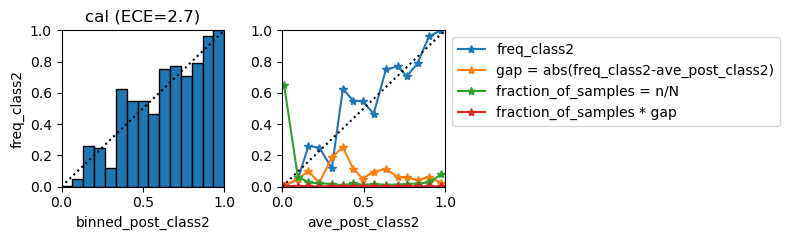

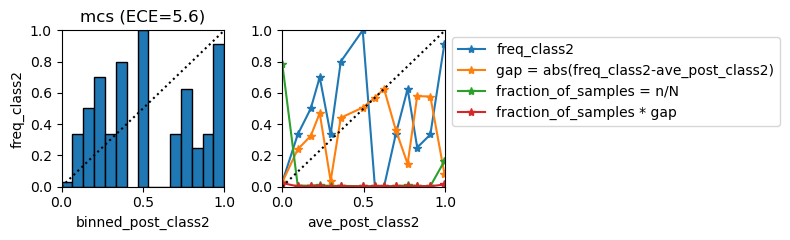

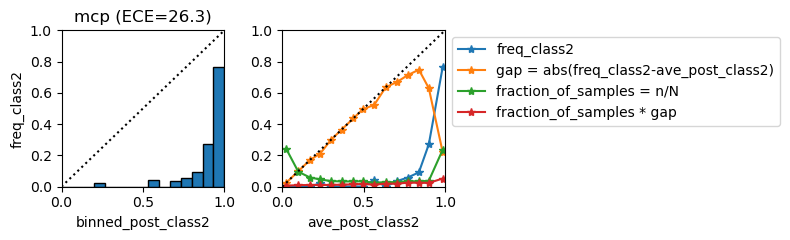

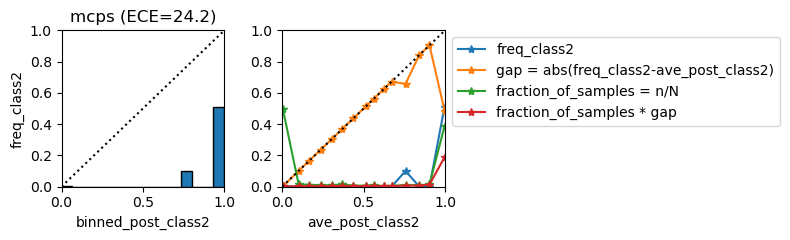

In [17]:
for j, score_name in enumerate(score_names):

    scores = score_dict[score_name]    
    metric_value, ys, xs, counts, limits = metric_dict['ECE'](scores, targets, return_values=True, M=nbins)
    plot_reliability_diagram(ys, xs, counts, limits, title=score_name, figsize=(8,2.5))



Some observations for K=2:

1. The plot for cal scores is not on the diagonal, though it should be since we know those scores are perfectly calibrated. This happens simply because the number of samples is small. You can try increasing N in the second cell to see how this plot does become diagonal for larger values of N. This simply shows the flimsiness of the histogram binning approach for small datasets.

2. For mcs and mcps we can see that only the two bins on the extremes have samples (see the green curve). These scores are all mapped to the same calibrated score (the frequency of class 2 in the corresponding bin). This transform does not do a good job at calibrating those scores: a posterior of 0.99 and a posterior of 0.999 should not be mapped to the same value. This explains why histogram binning works poorly for these scores and also why ECE does not correctly diagnose the degree of miscalibration in these scores.

3. We can also see the weakness of the reliability plot. It only tells a pretty small part of the story since it does not show the number of samples that feel in each bin. See, for example, the plot for mcps. Most samples are in the first and the last bin. The scores in the first bin are fine so the corresponding bar has a height of 0. The other bar, at 0.2 is a fluke. It does not affect the ECE value because very few samples fall in that bin (the red curve, which adds up to the ECE, is 0 at that point). So, looking at the reliability diagram we cannot really tell that much about the calibration quality of the system.

For K=10, remember that the problem is first mapped to a new binary problem that uses the confidences (the largest posterior):

1. We can see that, for this particular problem, the confidence is never smaller than 0.4. This minimum changes if you change the std value to something larger. 

2. The cal scores look miscalibrated, when they are actually not, for the same reason as above (too few samples in some bins cause a bad estimate of the frequency of class 2).
   
3. The mcp scores look reasonably well-calibrated but they are not. It just so happens that the confidences are reasonably well-calibrated, but that is not all that matters. If you want to make optimal decisions you need the full vector of posteriors to be well-calibrated.



## Score distributions

For further analysis, we can plot the score distributions. This is easy for the 2-class case, which is what we do below. The notebook 00_measure_perf_and_fix_calibration also shows a way to plot the scores for the multi-class case.

To make these plots you might want to set N to a large value to get smoother curves.


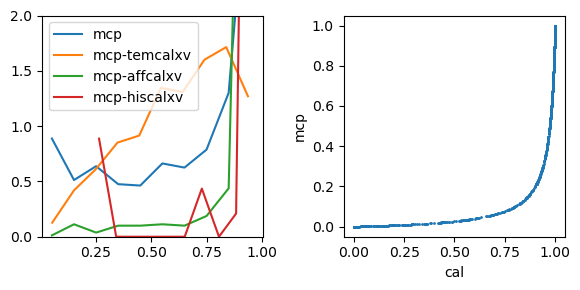

In [14]:
if K == 2:

    fig, axs = plt.subplots(1,2, figsize=(6,3))
    
    # You can change the score name to any of the other three
    score_name = 'mcp'
    ax = axs[0]
    for suffix in ['', '-temcalxv', '-affcalxv','-hiscalxv']:
        scores = score_dict[score_name+suffix]
        c, h = utils.make_hist(targets, np.exp(scores),nbins=10)
        ax.plot(c,h[0],label=score_name+suffix)    
    ax.set_ylim(0,2)
    ax.legend()

    # Plot the calibrated vs the scores above to see the effect of the corresponding miscalibration. Basically, most of the scores
    # have values close to 0 or 1, which is what happens in overfitting DNNs trained with cross-entropy
    ax = axs[1]
    ax.scatter(np.exp(score_dict['cal'][:,0]), np.exp(score_dict[score_name][:,0]), s=1) 
    ax.set_xlabel('cal')
    ax.set_ylabel(score_name)

    plt.tight_layout()